In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
pd.options.display.float_format = "{:,.3f}".format

In [3]:
%run ../utils/results_explore.py

<Figure size 640x480 with 0 Axes>

In [4]:
protocols_dict = {f"{ts}_{relation}": {'train_structure': ts, 'relation_type': relation} 
                  for ts in ["LS", "OTM", "MTO"] for relation in ['select_only', 'select_reject']}
protocol_names = list(protocols_dict.keys())

In [5]:
regrets_dict = {}
for prtcl in protocol_names:
    path = "salidas/"+prtcl+"regrets"
    with open(path, 'r') as fr:
        regret_list = fr.read().splitlines()
    protocols_dict[prtcl]['regrets'] = regret_list
    regrets_dict[prtcl] = regret_list

In [6]:
regrets_df = pd.DataFrame(regrets_dict).astype("float").reset_index()
regrets_df.sample(5)

,index,LS_select_only,LS_select_reject,OTM_select_only,OTM_select_reject,MTO_select_only,MTO_select_reject
11232,11232,348.000,"1,354.000",362.000,"1,173.000",73.000,940.000
12572,12572,390.000,"1,368.000",401.000,"1,182.000",75.000,986.000
14711,14711,454.000,"1,383.000",467.000,"1,191.000",83.000,"1,027.000"
5087,5087,218.000,"1,196.000",216.000,"1,071.000",51.000,595.000
15207,15207,472.000,"1,385.000",481.000,"1,193.000",85.000,"1,033.000"


In [7]:
regrets_df_melt = regrets_df.melt(id_vars=['index'],
                var_name='Protocol', 
                value_name='Regret')
regrets_df_melt.columns = ['Round', 'Protocol', 'Regret']

regret_info_arr = np.array(
    [[protocols_dict[ptr_nm]['train_structure'],
      (protocols_dict[ptr_nm]['relation_type']).replace("_"," ")] 
     for ptr_nm in regrets_df_melt.Protocol]
)

regrets_df_melt['Train structure'] = regret_info_arr[:,0]
regrets_df_melt['Relation type'] = regret_info_arr[:,1]

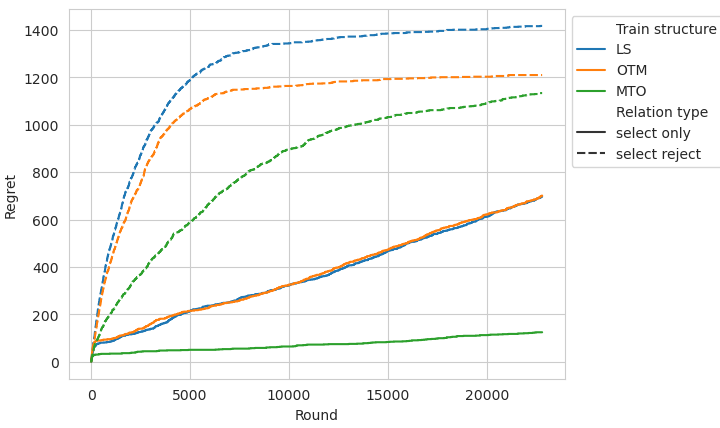

In [8]:
# sns.set_style("whitegrid")
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(
        data = regrets_df_melt,
        x = 'Round',
        y = 'Regret',
        hue = 'Train structure',
        style = 'Relation type')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('salidas/regrets_plot.pdf', bbox_inches='tight')

In [9]:
output_df = pd.DataFrame()
for prtcl in protocol_names:
    path = "salidas/"+prtcl+".pkl"
    prtcl_out = pd.read_pickle(path)  
    prtcl_out["protocol"]= prtcl
    protocols_dict[prtcl]["output"] = prtcl_out
    output_df = pd.concat([output_df, prtcl_out])
    

In [10]:
train_info_arr = np.array([[protocols_dict[ptr_nm]['train_structure'], 
  (protocols_dict[ptr_nm]['relation_type']).replace("_"," ")] 
 for ptr_nm in output_df.protocol])

In [11]:
output_df['train_structure'] = train_info_arr[:,0]
output_df['relation_type'] = train_info_arr[:,1]


In [12]:
# out_vals = pd.DataFrame(
output_df.pivot_table(
    index = ['train_structure', 'relation_type'],
    columns = 'sample_subset',
    values = 'response_score',
    aggfunc = 'mean'
)
# )

sample_subset                  baseline  reflexivity  symmetry  transitivity
train_structure relation_type                                               
LS              select only       0.984        0.466     0.305         0.326
                select reject     0.999        0.415     0.407         0.427
MTO             select only       0.995        0.314     0.208         0.220
                select reject     0.993        0.248     0.207         0.214
OTM             select only       0.984        0.452     0.010         0.423
                select reject     0.998        0.339     0.014         0.429

In [66]:
prtcl_mn = 5
protocol_names[prtcl_mn]

'MTO_select_reject'

In [67]:
protocol_output = protocols_dict[protocol_names[prtcl_mn]]["output"]

In [68]:
protocol_output.sample(10)

,sample_subset,st_sample,st_comp1,st_comp2,st_comp3,option_answer,st_comparison,agent_response,response_score,sample_member,comparison_member,protocol
132365,transitivity,E2,A4,B1,C2,O_3,C2,O_1,0,E,C,MTO_select_reject
55579,symmetry,A4,D5,B4,A2,O_2,B4,O_3,0,A,B,MTO_select_reject
51872,symmetry,A1,C4,A2,B1,O_3,B1,O_2,0,A,B,MTO_select_reject
116151,transitivity,D2,C2,E3,D4,O_1,C2,O_2,0,D,C,MTO_select_reject
140367,transitivity,E4,D4,A3,D1,O_1,D4,O_2,0,E,D,MTO_select_reject
9743,baseline,C4,C3,E3,A4,O_3,A4,O_3,1,C,A,MTO_select_reject
58795,symmetry,A2,C5,C2,C3,O_2,C2,O_3,0,A,C,MTO_select_reject
120601,transitivity,D1,D5,E1,E2,O_2,E1,O_3,0,D,E,MTO_select_reject
89075,transitivity,B4,A3,D3,E4,O_3,E4,O_1,0,B,E,MTO_select_reject
10919,baseline,C5,C4,C3,A5,O_3,A5,O_3,1,C,A,MTO_select_reject


In [69]:
protocol_output.loc[protocol_output.sample_subset=="baseline", "sample_subset"]="train"

In [70]:
evaluation_graph_dat = get_agent_graph_dat(
    agent_info_df = protocol_output, 
    metric_column = "response_score"
)
evaluation_graph_dat.response_score = evaluation_graph_dat.response_score.astype("float")

In [71]:
print (
    "NCB agent on",
    protocols_dict[protocol_names[prtcl_mn]]['train_structure'], "training with", 
    (protocols_dict[protocol_names[prtcl_mn]]['relation_type']).replace("_", " "), "relations"
)

NCB agent on MTO training with select reject relations


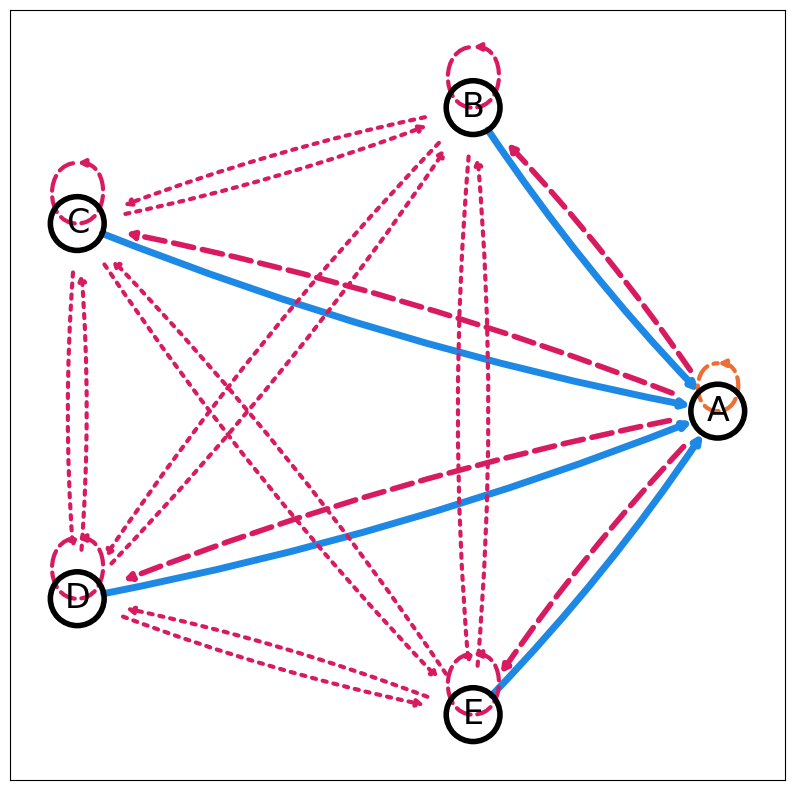

In [72]:
plot_graph_results(
    graph_dat_plot = evaluation_graph_dat, 
    metric_column = "response_score",
    node_origin = "sample_member",
    node_destiny = "comparison_member",
    trial_group = "sample_subset",
    minimal_cut_value = .9,
    random_level = .35
)

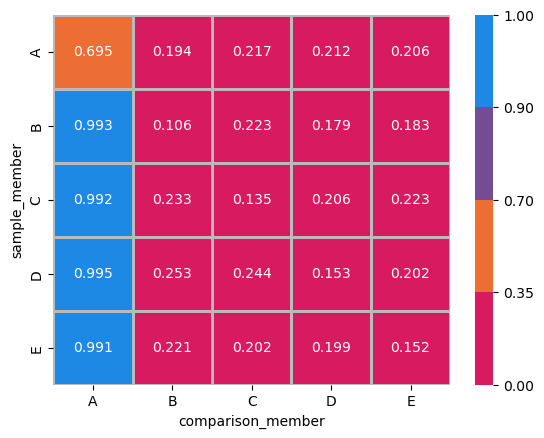

In [73]:
heatmap , results = plot_heatmap_dat(
    graph_dat_plot = evaluation_graph_dat, 
    metric_column = "response_score",
    minimal_cut_value = .9,
    random_level = .35
)